In [1]:
import os
from glob import glob
import numpy as np
import pandas as pd
import ROOT

Welcome to JupyROOT 6.28/00


In [2]:
files = glob("./fit_result/*.txt") # ここに各電圧のガウスフィットの結果をコピペしてある
files.sort()
print(files)

['./fit_result/412.txt', './fit_result/414.txt', './fit_result/416.txt', './fit_result/418.txt', './fit_result/420.txt']


In [3]:
Vs = []
d_means = []
d_mean_errors = []

for file in files:
    V = int(os.path.basename(file).replace(".txt", ""))/10
    with open(file) as f:
        lines = f.readlines()
        # "Mean"が含まれる行を抽出
        lines = [line for line in lines if "Mean" in line]
        # 各行で"Mean"の直後の値(value)とその次の値(error)を抽出
        values = [line.split()[2] for line in lines]
        errors = [line.split()[3] for line in lines]

        # 文字列をfloatに変換
        values = np.array(list(map(float, values)))
        errors = np.array(list(map(float, errors)))

        # 隣り合う値の差dとその誤差e_dを計算
        d = np.diff(values)
        ed = np.sqrt(errors[:-1]**2 + errors[1:]**2)

        # 誤差で加重平均を計算
        mean = np.average(d, weights=1/ed)
        # 誤差の和の平方根の逆数を計算
        error = 1/np.sqrt(np.sum(ed))
        # print(f"{V=}, {mean=:.4f}, {error=:.4f}")

        Vs.append(V)
        d_means.append(mean)
        d_mean_errors.append(error)

# データフレームを作成
df = pd.DataFrame({
    "V": Vs,
    "d": d_means,
    "e_d": d_mean_errors
})

df

[0.162292 0.143039 0.130058 0.191513 0.18534  0.433787]
[0.162292 0.143039 0.130058 0.191513 0.18534 ]
[0.143039 0.130058 0.191513 0.18534  0.433787]
[0.130057  0.118579  0.0979914 0.13264   0.153735  0.236268 ]
[0.130057  0.118579  0.0979914 0.13264   0.153735 ]
[0.118579  0.0979914 0.13264   0.153735  0.236268 ]
[0.113194  0.093473  0.0958482 0.113046  0.283663  0.306579 ]
[0.113194  0.093473  0.0958482 0.113046  0.283663 ]
[0.093473  0.0958482 0.113046  0.283663  0.306579 ]
[0.107194  0.0958058 0.102095  0.0981602 0.158077  0.215023 ]
[0.107194  0.0958058 0.102095  0.0981602 0.158077 ]
[0.0958058 0.102095  0.0981602 0.158077  0.215023 ]
[0.103358  0.0815975 0.0947672 0.0942792 0.15715   0.185158 ]
[0.103358  0.0815975 0.0947672 0.0942792 0.15715  ]
[0.0815975 0.0947672 0.0942792 0.15715   0.185158 ]


,V,d,e_d
0,41.2,12.653034,0.851444
1,41.4,13.572131,1.010324
2,41.6,14.141455,0.931724
3,41.8,15.397653,1.067000
4,42.0,16.147852,1.106655


In [4]:
r = 0.25
A = 100
e = 1.602176634e-19 / 1e-12 # [C] -> [pC]

G = (df["d"] * r) / (A * e)
e_G = (df["e_d"] * r) / (A * e)
df["G"] = G
df["e_G"] = e_G

38.3206 +/- 20.0417

****************************************
Minimizer is Linear / Migrad
Chi2                      =    0.0885366
NDf                       =            3
p0                        = -2.62073e+06   +/-   1.0076e+06  
p1                        =      68389.6   +/-   24248       


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


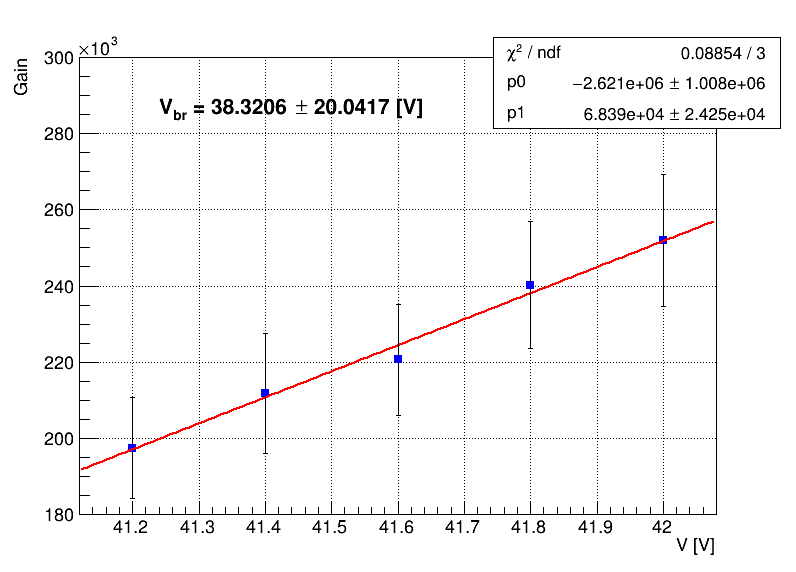

In [9]:
# lenear fitting by PyROOT
c1 = ROOT.TCanvas("c1","A Simple Graph with error bars", 800, 600)
c1.SetGrid()

gr = ROOT.TGraphErrors(
    len(df["V"]),
    df["V"].values, df["G"].values,
    np.zeros(len(df["V"])), df["e_G"].values
)

# blank title
gr.SetTitle("")
# set axis title
gr.GetXaxis().SetTitle("V [V]")
gr.GetYaxis().SetTitle("Gain")
# set axis range
gr.GetXaxis().SetRangeUser(0, 5)
gr.GetYaxis().SetRangeUser(180e3, 300e3)


gr.SetMarkerColor(4)
gr.SetMarkerStyle(21)

gr.Fit("pol1")

gr.Draw("AP")

# get fit result
fit = gr.GetFunction("pol1")

# p0: constant, p1: slope
p0 = fit.GetParameter(0)
p1 = fit.GetParameter(1)

e_p0 = fit.GetParError(0)
e_p1 = fit.GetParError(1)

V_br = -p0/p1
e_V_br = np.sqrt((e_p0/p1)**2 + (p0*e_p1/p1**2)**2)

print(f"{V_br:.4f} +/- {e_V_br:.4f}") # 誤差でかくね？

# draw text
text = ROOT.TLatex()
text.SetTextSize(0.04)
text.DrawLatexNDC(0.2, 0.8, f"V_{{br}} = {V_br:.4f} #pm {e_V_br:.4f} [V]")

# show fit panel
ROOT.gStyle.SetOptFit(111)

c1.Draw()